# Avance 3 — Baseline (Equipo 20)
**Proyecto:** Detección / clasificación de anillos en galaxias (imágenes FITS + variables tabulares)  
**Objetivo del notebook:** Construir un **modelo baseline** reproducible que sirva como **marco de referencia** para iteraciones futuras.

# Nota par el equipo Este notebook intenta:
- Probar colores vs escala de grises y combinaciones de contrastes (muy rojo/muy azul).  
- Usar color index maps (p. ej. ND-like: (g-r)/(g+r), (r-z)/(r+z), (g-z)/(g+z)).  
- Experimentar con preprocesamientos(asinh, clipping, reducción de tamaño).  
- Rebalanceo de clases (class_weight + oversampling opcional).  
- Bloque preparado para integrar un 2do dataset
- Leer archivos FITS y analizar.  
- Excluir anillos nucleares y pseudoanillos (limitación del dataset).

---

## Requerimientos del entregable (Avance 3)
- 3.1 Definir **medidas de calidad** del modelo.
- 3.2 Proveer un **baseline** para evaluar viabilidad y mejorar modelos más avanzados.


In [40]:
!pip -q install astropy photutils scikit-image imbalanced-learn

import os
import numpy as np
import pandas as pd
from collections import Counter

import matplotlib.pyplot as plt
import os, glob, requests
from tqdm import tqdm


from astropy.io import fits
from astropy.visualization import make_lupton_rgb

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance


try:
    from imblearn.over_sampling import RandomOverSampler
    IMB_AVAILABLE = True
except Exception:
    IMB_AVAILABLE = False

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# =========================
# Montar Google Drive
# =========================
from google.colab import drive
drive.mount("/content/drive")

#HOME_PATH = '/content/drive/MyDrive/Colab Notebooks/MNA/TC5035.10 - Proyecto Integrador/Proyecto'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1) Configuración de rutas y archivos


In [50]:
# === (1) Paths ===
DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/MNA/TC5035.10 - Proyecto Integrador/Proyecto/Dataset"
IMAGES_DIR = "/content/drive/MyDrive/Colab Notebooks/MNA/TC5035.10 - Proyecto Integrador/Proyecto/Images"
CATALOG_FITS = os.path.join(DATA_DIR, "dataset.fits")

# Segundo dataset (placeholder)
#DATASET2_DIR = "./Dataset2"
#CATALOG2_FITS = os.path.join(DATASET2_DIR, "dataset2.fits")

print("CATALOG_FITS exists:", os.path.exists(CATALOG_FITS))
print("IMAGES_DIR exists:", os.path.exists(IMAGES_DIR))


CATALOG_FITS exists: True
IMAGES_DIR exists: True


In [51]:
os.makedirs(IMAGES_DIR, exist_ok=True)

def download_legacy_fits(objid_str, ra, dec, size=128, pixscale=0.262):
    url = (
        "https://www.legacysurvey.org/viewer/fits-cutout?"
        f"ra={ra}&dec={dec}&layer=ls-dr10&pixscale={pixscale}&size={size}&bands=grz"
    )
    out = os.path.join(IMAGES_DIR, f"{objid_str}.fits")

    if os.path.exists(out):
        return out

    r = requests.get(url, timeout=60)
    r.raise_for_status()
    with open(out, "wb") as f:
        f.write(r.content)
    return out

# Si no hay imágenes, descarga muestra
existing = glob.glob(os.path.join(IMAGES_DIR, "*.fits"))

if len(existing) == 0:
    print("No hay imágenes. Descargando muestra para baseline...")

    sample_df = df1.sample(
        n=min(300, len(df1)),
        random_state=42
    )

    for _, row in tqdm(sample_df.iterrows(), total=len(sample_df)):
        try:
            download_legacy_fits(
                row["objID_str"],
                row["ra"],
                row["dec"],
                size=128
            )
        except:
            pass

    print("Descarga terminada.")
else:
    print("Ya existen imágenes en la carpeta.")


Ya existen imágenes en la carpeta.


## 2) Carga del catálogo FITS (tabular)


In [52]:
def fits_table_to_df(fits_path: str, ext: int = 1) -> pd.DataFrame:
    """
    Lee tabla FITS -> DataFrame de pandas, forzando little-endian (NumPy 2.0 safe)
    para evitar errores tipo:
    'Big-endian buffer not supported on little-endian compiler'
    """
    with fits.open(fits_path, memmap=False) as hdul:
        data = hdul[ext].data
        arr = np.asarray(data)

        # Para tablas estructuradas FITS, forzamos conversión por campos
        if arr.dtype.fields is not None:
            arr2 = np.empty(arr.shape, dtype=arr.dtype.newbyteorder("<"))
            for name in arr.dtype.names:
                col = np.asarray(arr[name])
                if col.dtype.byteorder not in ("=", "|"):
                    col = col.byteswap().view(col.dtype.newbyteorder("<"))
                arr2[name] = col
            arr = arr2
        else:
            # No estructurado (raro en catálogos), pero por si acaso:
            if arr.dtype.byteorder not in ("=", "|"):
                arr = arr.byteswap().view(arr.dtype.newbyteorder("<"))

        return pd.DataFrame.from_records(arr)

# ====== PIPELINE LIMPIO ======

# 1) Leer catálogo
df_raw = fits_table_to_df(CATALOG_FITS, ext=1)

# ====== Mapeo de clases de anillos ======

ANILLOS_MAP = {
    0:  "Sin",
    2:  "Nuclear",
    4:  "Interno",
    8:  "Externo",
    12: "Interno+Externo",
    16: "Pseudo"
}

def to_4class(anillos_value):
    """
    Mapea la etiqueta original a 4 clases:
    0 -> Sin anillo
    1 -> Interno
    2 -> Externo
    3 -> Interno + Externo

    Descarta nuclear (2) y pseudo (16)
    """
    if anillos_value in (2, 16):
        return None
    if anillos_value == 0:
        return 0
    if anillos_value == 4:
        return 1
    if anillos_value == 8:
        return 2
    if anillos_value == 12:
        return 3
    return None


# Etiqueta descriptiva (para análisis exploratorio)
df_raw["anillos_label"] = df_raw["anillos"].map(ANILLOS_MAP).fillna("Desconocido")

# Target final para modelado
df_raw["ring_class"] = df_raw["anillos"].apply(to_4class)

print("Distribución original anillos:")
print(df_raw["anillos_label"].value_counts())

print("\nDistribución ring_class (incluye NaN antes de filtrar nuclear/pseudo):")
print(df_raw["ring_class"].value_counts(dropna=False))


# 2) Target (4 clases) + etiquetas originales (opcional)
df_raw["anillos_label"] = df_raw["anillos"].map(ANILLOS_MAP).fillna("Desconocido")
df_raw["ring_class"] = df_raw["anillos"].apply(to_4class)

# 3) Eliminar nuclear/pseudo (ring_class NaN)
df_clean = df_raw.dropna(subset=["ring_class"]).copy()

# 4) Filtrar z ± 2σ (outliers)
df_clean["z"] = pd.to_numeric(df_clean["z"], errors="coerce")
z_mean = df_clean["z"].mean()
z_std  = df_clean["z"].std()
df_clean = df_clean[(df_clean["z"] >= z_mean - 2*z_std) & (df_clean["z"] <= z_mean + 2*z_std)].copy()

# 5) Features tabulares (baseline tabular)
df_clean["z_log1p"] = np.log1p(df_clean["z"].clip(lower=0))

df_clean["ra"]  = pd.to_numeric(df_clean["ra"], errors="coerce")
df_clean["dec"] = pd.to_numeric(df_clean["dec"], errors="coerce")

ra_rad  = np.deg2rad(df_clean["ra"])
dec_rad = np.deg2rad(df_clean["dec"])

df_clean["ra_sin"]  = np.sin(ra_rad)
df_clean["ra_cos"]  = np.cos(ra_rad)
df_clean["dec_sin"] = np.sin(dec_rad)
df_clean["dec_cos"] = np.cos(dec_rad)

# 6) Link a imágenes (si existen) -> df_img
df_clean["objID_str"] = df_clean["objID"].astype(str).str.replace(".0", "", regex=False)

def find_img_path(objid_str: str):
    p = os.path.join(IMAGES_DIR, f"{objid_str}.fits")
    return p if os.path.exists(p) else None

df_clean["img_path"] = df_clean["objID_str"].apply(find_img_path)
df_img = df_clean.dropna(subset=["img_path"]).copy()

print("df_clean shape (tabular listo):", df_clean.shape)
print("df_img shape (con imágenes):   ", df_img.shape)
print("Clases:", df_clean["ring_class"].value_counts().sort_index().to_dict())


Distribución original anillos:
anillos_label
Sin                6660
Interno             857
Interno+Externo     372
Pseudo              342
Externo             186
Nuclear             111
Name: count, dtype: int64

Distribución ring_class (incluye NaN antes de filtrar nuclear/pseudo):
ring_class
0.0    6660
1.0     857
NaN     453
3.0     372
2.0     186
Name: count, dtype: int64
df_clean shape (tabular listo): (7723, 14)
df_img shape (con imágenes):    (298, 14)
Clases: {0.0: 6346, 1.0: 837, 2.0: 177, 3.0: 363}


## 3) Ingeniería de características tabulares


In [53]:
# Features tabulares

df_clean["z"]  = pd.to_numeric(df_clean["z"], errors="coerce")
df_clean["ra"] = pd.to_numeric(df_clean["ra"], errors="coerce")
df_clean["dec"]= pd.to_numeric(df_clean["dec"], errors="coerce")

df_clean["z_log1p"] = np.log1p(df_clean["z"].clip(lower=0))
df_clean["z_bin"] = pd.qcut(df_clean["z"], q=3, labels=["low","mid","high"])

ra_rad  = np.deg2rad(df_clean["ra"])
dec_rad = np.deg2rad(df_clean["dec"])

df_clean["ra_sin"]  = np.sin(ra_rad)
df_clean["ra_cos"]  = np.cos(ra_rad)
df_clean["dec_sin"] = np.sin(dec_rad)
df_clean["dec_cos"] = np.cos(dec_rad)

df_clean[[
    "objID","ra","dec","z","z_log1p",
    "ra_sin","ra_cos","dec_sin","dec_cos",
    "ring_class"
]].head()


,objID,ra,dec,z,z_log1p,ra_sin,ra_cos,dec_sin,dec_cos,ring_class
0,1237648721210769659,134.44717,-0.199973,0.028206,0.027815,0.713896,-0.700251,-0.003490,0.999994,0.0
1,1237648705657307354,198.23356,0.941188,0.048037,0.046919,-0.312891,-0.949789,0.016426,0.999865,0.0
2,1237648705120895059,199.29492,0.527571,0.024114,0.023828,-0.330431,-0.943830,0.009208,0.999958,0.0
3,1237648720150724863,165.74061,-0.962095,0.033483,0.032935,0.246312,-0.969191,-0.016791,0.999859,0.0
4,1237649919509594232,31.37202,13.251016,0.024694,0.024394,0.520593,0.853805,0.229218,0.973375,0.0


## 4) Lectura de imágenes FITS y features visuales (baseline)
Probamos **gray**, **idx** (color index maps) y **mix** (gray + idx), con **reducción de tamaño**.


In [54]:


def safe_div(a, b, eps=1e-6):
    return a / (b + eps)

def asinh_norm(x, clip_percentile=99.5):
    x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
    hi = np.percentile(np.abs(x), clip_percentile)
    if hi <= 0:
        return np.zeros_like(x, dtype=np.float32)
    x = np.clip(x, -hi, hi)
    y = np.arcsinh(x)
    y = y - y.min()
    if y.max() > 0:
        y = y / y.max()
    return y.astype(np.float32)

def read_grz_from_fits(fits_path: str):
    """
    Lee un cutout FITS y devuelve (g, r, z) como float32.
    Soporta formatos comunes:
      - cube en HDU0: (3, H, W) o (H, W, 3)
      - imágenes separadas en extensiones (menos común)
    """
    with fits.open(fits_path, memmap=False) as hdul:
        # Intenta primero HDU0
        data = hdul[0].data

        # Si HDU0 no tiene data, usa HDU1
        if data is None and len(hdul) > 1:
            data = hdul[1].data

        if data is None:
            raise ValueError("FITS sin datos en HDU0/HDU1")

        arr = np.asarray(data)

        # Caso A: (3, H, W)
        if arr.ndim == 3 and arr.shape[0] == 3:
            g = arr[0].astype(np.float32)
            r = arr[1].astype(np.float32)
            z = arr[2].astype(np.float32)
            return g, r, z

        # Caso B: (H, W, 3)
        if arr.ndim == 3 and arr.shape[-1] == 3:
            g = arr[..., 0].astype(np.float32)
            r = arr[..., 1].astype(np.float32)
            z = arr[..., 2].astype(np.float32)
            return g, r, z

        raise ValueError(f"Formato inesperado para cutout grz: shape={arr.shape}")

def lupton_rgb(g, r, z, Q=10, stretch=0.5):
    # Nota: make_lupton_rgb espera (R,G,B) pero aquí queremos mapear (r,g,z)
    return make_lupton_rgb(r, g, z, Q=Q, stretch=stretch)

def grayscale_from_rgb(rgb_uint8):
    rgb = rgb_uint8.astype(np.float32) / 255.0
    gray = 0.2989*rgb[...,0] + 0.5870*rgb[...,1] + 0.1140*rgb[...,2]
    return gray.astype(np.float32)

def resize_nearest(img, out_h=64, out_w=64):
    in_h, in_w = img.shape[:2]
    y_idx = (np.linspace(0, in_h - 1, out_h)).astype(int)
    x_idx = (np.linspace(0, in_w - 1, out_w)).astype(int)
    if img.ndim == 2:
        return img[np.ix_(y_idx, x_idx)]
    return img[np.ix_(y_idx, x_idx, np.arange(img.shape[2]))]

def extract_image_features(fits_path: str, size=64, mode="mix"):
    """
    mode:
      - rgb: pixeles RGB (flatten)
      - gray: grayscale (flatten)
      - idx: 3 mapas de índice de color (flatten)
      - mix: gray + idx (flatten)  <-- recomendado por feedback
    """
    g, r, z = read_grz_from_fits(fits_path)

    # Color index maps (tipo ND)
    idx_gr = safe_div((g - r), (g + r))
    idx_rz = safe_div((r - z), (r + z))
    idx_gz = safe_div((g - z), (g + z))

    # Normalización asinh (estabiliza rangos)
    g_n = asinh_norm(g); r_n = asinh_norm(r); z_n = asinh_norm(z)
    idx_gr_n = asinh_norm(idx_gr); idx_rz_n = asinh_norm(idx_rz); idx_gz_n = asinh_norm(idx_gz)

    # RGB lupton + resize
    rgb = lupton_rgb(g_n, r_n, z_n)              # uint8
    rgb_rs = resize_nearest(rgb, size, size)

    # grayscale + resize
    gray = grayscale_from_rgb(rgb_rs)
    gray_rs = resize_nearest(gray, size, size)

    # índices apilados + resize
    idx_stack = np.stack([idx_gr_n, idx_rz_n, idx_gz_n], axis=-1)
    idx_rs = resize_nearest(idx_stack, size, size)

    if mode == "rgb":
        return (rgb_rs.astype(np.float32) / 255.0).reshape(-1)
    if mode == "gray":
        return gray_rs.reshape(-1)
    if mode == "idx":
        return idx_rs.reshape(-1)
    if mode == "mix":
        return np.concatenate([gray_rs.reshape(-1), idx_rs.reshape(-1)], axis=0)

    raise ValueError("mode must be one of: rgb, gray, idx, mix")

print("Image feature functions ready.")


Image feature functions ready.


### 4.2 Unir catálogo con imágenes locales


In [55]:

df_clean["objID_str"] = df_clean["objID"].astype(str).str.replace(".0", "", regex=False)

def find_img_path(objid_str: str):
    # 1) esperado: <objID>.fits
    cand = os.path.join(IMAGES_DIR, f"{objid_str}.fits")
    if os.path.exists(cand):
        return cand

    # 2) por si están comprimidos o con extensión distinta
    matches = glob.glob(os.path.join(IMAGES_DIR, f"{objid_str}.fits*"))  # fits.fz, etc.
    if matches:
        return matches[0]

    matches = glob.glob(os.path.join(IMAGES_DIR, f"{objid_str}.fit*"))   # fit, fits
    if matches:
        return matches[0]

    return None

df_clean["img_path"] = df_clean["objID_str"].apply(find_img_path)

print("Con imagen:", df_clean["img_path"].notna().sum(), "/", len(df_clean))

df_img = df_clean.dropna(subset=["img_path"]).copy()
df_img[["objID_str", "img_path", "ring_class"]].head()


Con imagen: 298 / 7723


,objID_str,img_path,ring_class
23,1237648722312298550,/content/drive/MyDrive/Colab Notebooks/MNA/TC5...,0.0
37,1237648704602243187,/content/drive/MyDrive/Colab Notebooks/MNA/TC5...,0.0
62,1237648722830426252,/content/drive/MyDrive/Colab Notebooks/MNA/TC5...,0.0
66,1237648704057573661,/content/drive/MyDrive/Colab Notebooks/MNA/TC5...,0.0
81,1237648722299715771,/content/drive/MyDrive/Colab Notebooks/MNA/TC5...,0.0


## 5) Métricas y modelos baseline
**Métricas principales (clases desbalanceadas):** Balanced Accuracy y F1-macro.


In [56]:
def find_img_path(objid_str: str):
    direct = os.path.join(IMAGES_DIR, f"{objid_str}.fits")
    if os.path.exists(direct):
        return direct

    matches = glob.glob(os.path.join(IMAGES_DIR, f"*{objid_str}*.fits"))
    return matches[0] if matches else None


df_clean["img_path"] = df_clean["objID_str"].apply(find_img_path)

df_img = df_clean.dropna(subset=["img_path"]).copy()

print("Con imagen:", len(df_img))


Con imagen: 298


In [57]:
#checar que existen los FITS en el directorio
print("IMAGES_DIR =", IMAGES_DIR)
files = glob.glob(os.path.join(IMAGES_DIR, "*.fits"))
print("N FITS =", len(files))
print("Ejemplos:", files[:10])


IMAGES_DIR = /content/drive/MyDrive/Colab Notebooks/MNA/TC5035.10 - Proyecto Integrador/Proyecto/Images
N FITS = 298
Ejemplos: ['/content/drive/MyDrive/Colab Notebooks/MNA/TC5035.10 - Proyecto Integrador/Proyecto/Images/1237662236396683371.fits', '/content/drive/MyDrive/Colab Notebooks/MNA/TC5035.10 - Proyecto Integrador/Proyecto/Images/1237661383843840184.fits', '/content/drive/MyDrive/Colab Notebooks/MNA/TC5035.10 - Proyecto Integrador/Proyecto/Images/1237659324418556303.fits', '/content/drive/MyDrive/Colab Notebooks/MNA/TC5035.10 - Proyecto Integrador/Proyecto/Images/1237655691402805427.fits', '/content/drive/MyDrive/Colab Notebooks/MNA/TC5035.10 - Proyecto Integrador/Proyecto/Images/1237678617430196472.fits', '/content/drive/MyDrive/Colab Notebooks/MNA/TC5035.10 - Proyecto Integrador/Proyecto/Images/1237658492269297866.fits', '/content/drive/MyDrive/Colab Notebooks/MNA/TC5035.10 - Proyecto Integrador/Proyecto/Images/1237655504036627107.fits', '/content/drive/MyDrive/Colab Notebooks

In [58]:
TARGET = "ring_class"
TAB_FEATURES = ["z", "z_log1p", "ra_sin", "ra_cos", "dec_sin", "dec_cos"]

# Si hay imágenes, usar df_img; si no, usar df_clean
df_base = df_img if len(df_img) > 0 else df_clean

df_base = df_base.dropna(subset=TAB_FEATURES + [TARGET]).copy()

print("Dataset base shape:", df_base.shape)

X = df_base[TAB_FEATURES].astype(float)
y = df_base[TARGET].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print("Train class dist:", Counter(y_train))
print("Test  class dist:", Counter(y_test))


Dataset base shape: (298, 15)
Train class dist: Counter({0: 200, 1: 29, 3: 7, 2: 2})
Test  class dist: Counter({0: 51, 1: 7, 3: 2})


In [59]:
def eval_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)

    pred_tr = model.predict(X_train)
    pred_te = model.predict(X_test)

    metrics = {
        "model": name,
        "acc_train": accuracy_score(y_train, pred_tr),
        "acc_test": accuracy_score(y_test, pred_te),
        "bal_acc_train": balanced_accuracy_score(y_train, pred_tr),
        "bal_acc_test": balanced_accuracy_score(y_test, pred_te),
        "f1m_train": f1_score(y_train, pred_tr, average="macro", zero_division=0),
        "f1m_test": f1_score(y_test, pred_te, average="macro", zero_division=0),
    }
    return metrics, pred_te


## 6) Baseline A: Tabular-only


In [60]:
models_tab = []

dummy_mf = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)
dummy_strat = DummyClassifier(strategy="stratified", random_state=RANDOM_STATE)

logreg_tab = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        random_state=RANDOM_STATE
    ))
])

rf_tab = RandomForestClassifier(
    n_estimators=400,
    class_weight="balanced_subsample",
    random_state=RANDOM_STATE,
    n_jobs=-1
)

for name, m in [
    ("Dummy-most_frequent (tab)", dummy_mf),
    ("Dummy-stratified (tab)", dummy_strat),
    ("LogReg-balanced (tab)", logreg_tab),
    ("RF-balanced (tab)", rf_tab),
]:
    res, _ = eval_model(name, m, X_train, y_train, X_test, y_test)
    models_tab.append(res)

pd.DataFrame(models_tab).sort_values("bal_acc_test", ascending=False)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


,model,acc_train,acc_test,bal_acc_train,bal_acc_test,f1m_train,f1m_test
2,LogReg-balanced (tab),0.403361,0.266667,0.542211,0.346872,0.234292,0.188443
0,Dummy-most_frequent (tab),0.840336,0.850000,0.250000,0.333333,0.228311,0.306306
1,Dummy-stratified (tab),0.726891,0.733333,0.245733,0.328665,0.248287,0.252451
3,RF-balanced (tab),1.000000,0.833333,1.000000,0.326797,1.000000,0.303030


## 7) Baseline B: Imagen + (opcional) Tabular
En esta versión usamos solo la imagen (pixeles) para simplificar.  
En iteración futura pueden concatenar `X_tab` a la matriz de imagen.


In [63]:
#verificar imagenes

print("df_img shape:", df_img.shape)
print("Columnas:", df_img.columns)
print("Ring_class dist:", df_img["ring_class"].value_counts())


df_img shape: (298, 15)
Columnas: Index(['objID', 'ra', 'dec', 'z', 'anillos', 'anillos_label', 'ring_class',
       'z_log1p', 'ra_sin', 'ra_cos', 'dec_sin', 'dec_cos', 'objID_str',
       'img_path', 'z_bin'],
      dtype='object')
Ring_class dist: ring_class
0.0    251
1.0     36
3.0      9
2.0      2
Name: count, dtype: int64


In [64]:
def build_image_matrix(df_subset: pd.DataFrame, size=64, mode="mix"):
    feats = []
    ok = []
    for i, p in enumerate(df_subset["img_path"].tolist()):
        try:
            feats.append(extract_image_features(p, size=size, mode=mode))
            ok.append(i)
        except Exception:
            continue
    X = np.vstack(feats) if len(feats) else np.empty((0, 0))
    return X, df_subset.iloc[ok].copy()


SIZE = 64

df_img2 = df_img.dropna(subset=["img_path", TARGET]).copy()
y_img = df_img2[TARGET].astype(int)

df_train, df_test = train_test_split(
    df_img2,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_img
)

Xtr_gray, dftr_gray = build_image_matrix(df_train, size=SIZE, mode="gray")
Xte_gray, dfte_gray = build_image_matrix(df_test,  size=SIZE, mode="gray")

Xtr_idx,  dftr_idx  = build_image_matrix(df_train, size=SIZE, mode="idx")
Xte_idx,  dfte_idx  = build_image_matrix(df_test,  size=SIZE, mode="idx")

Xtr_mix,  dftr_mix  = build_image_matrix(df_train, size=SIZE, mode="mix")
Xte_mix,  dfte_mix  = build_image_matrix(df_test,  size=SIZE, mode="mix")

ytr_gray = dftr_gray[TARGET].astype(int).to_numpy()
yte_gray = dfte_gray[TARGET].astype(int).to_numpy()

ytr_idx  = dftr_idx[TARGET].astype(int).to_numpy()
yte_idx  = dfte_idx[TARGET].astype(int).to_numpy()

ytr_mix  = dftr_mix[TARGET].astype(int).to_numpy()
yte_mix  = dfte_mix[TARGET].astype(int).to_numpy()

print("mix shapes:", Xtr_mix.shape, Xte_mix.shape)
print("Train class dist (mix):", Counter(ytr_mix))


mix shapes: (238, 16384) (60, 16384)
Train class dist (mix): Counter({np.int64(0): 200, np.int64(1): 29, np.int64(3): 7, np.int64(2): 2})


In [65]:
# Rebalanceo: class_weight + oversampling opcional
def maybe_oversample(X, y):
    if not IMB_AVAILABLE:
        return X, y, False
    ros = RandomOverSampler(random_state=RANDOM_STATE)
    X2, y2 = ros.fit_resample(X, y)
    return X2, y2, True

logreg_img = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        random_state=RANDOM_STATE
    ))
])

rf_img = RandomForestClassifier(
    n_estimators=400,
    class_weight="balanced_subsample",
    random_state=RANDOM_STATE,
    n_jobs=-1
)


In [67]:
def run_suite(Xtr, ytr, Xte, yte, label):
    if Xtr.size == 0 or Xte.size == 0 or len(ytr) == 0 or len(yte) == 0:
        rows = [{
            "model": f"SKIPPED ({label})",
            "acc_train": np.nan,
            "acc_test": np.nan,
            "bal_acc_train": np.nan,
            "bal_acc_test": np.nan,
            "f1m_train": np.nan,
            "f1m_test": np.nan,
        }]
        return pd.DataFrame(rows), {}

    rows = []
    preds = {}

    dummy = DummyClassifier(strategy="stratified", random_state=RANDOM_STATE)
    res, p = eval_model(f"Dummy-stratified ({label})", dummy, Xtr, ytr, Xte, yte)
    rows.append(res); preds[res["model"]] = p

    res, p = eval_model(f"LogReg-balanced ({label})", logreg_img, Xtr, ytr, Xte, yte)
    rows.append(res); preds[res["model"]] = p

    res, p = eval_model(f"RF-balanced ({label})", rf_img, Xtr, ytr, Xte, yte)
    rows.append(res); preds[res["model"]] = p

    return pd.DataFrame(rows).sort_values("bal_acc_test", ascending=False), preds


res_gray, _ = run_suite(Xtr_gray, ytr_gray, Xte_gray, yte_gray, f"gray@{SIZE}")
res_idx,  _ = run_suite(Xtr_idx,  ytr_idx,  Xte_idx,  yte_idx,  f"idx@{SIZE}")
res_mix,  _ = run_suite(Xtr_mix,  ytr_mix,  Xte_mix,  yte_mix,  f"mix@{SIZE}")

res_gray, res_idx, res_mix


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


(                        model  acc_train  acc_test  bal_acc_train  \
 2       RF-balanced (gray@64)   1.000000  0.850000       1.000000   
 0  Dummy-stratified (gray@64)   0.726891  0.733333       0.245733   
 1   LogReg-balanced (gray@64)   1.000000  0.733333       1.000000   
 
    bal_acc_test  f1m_train  f1m_test  
 2      0.333333   1.000000  0.306306  
 0      0.328665   0.248287  0.252451  
 1      0.328665   1.000000  0.322712  ,
                        model  acc_train  acc_test  bal_acc_train  \
 0  Dummy-stratified (idx@64)   0.726891  0.733333       0.245733   
 1   LogReg-balanced (idx@64)   1.000000  0.833333       1.000000   
 2       RF-balanced (idx@64)   1.000000  0.833333       1.000000   
 
    bal_acc_test  f1m_train  f1m_test  
 0      0.328665   0.248287  0.252451  
 1      0.326797   1.000000  0.303030  
 2      0.326797   1.000000  0.303030  ,
                        model  acc_train  acc_test  bal_acc_train  \
 1   LogReg-balanced (mix@64)   1.000000  0.83333

## 8) Reporte visual del baseline final (mix)


Baseline final: LogReg mix@64 (ROS)

Balanced Acc: 0.36134453781512604
F1-macro    : 0.36573208722741435

Classification report:
               precision    recall  f1-score   support

           0      0.857     0.941     0.897        51
           1      0.333     0.143     0.200         7
           3      0.000     0.000     0.000         2

    accuracy                          0.817        60
   macro avg      0.397     0.361     0.366        60
weighted avg      0.767     0.817     0.786        60



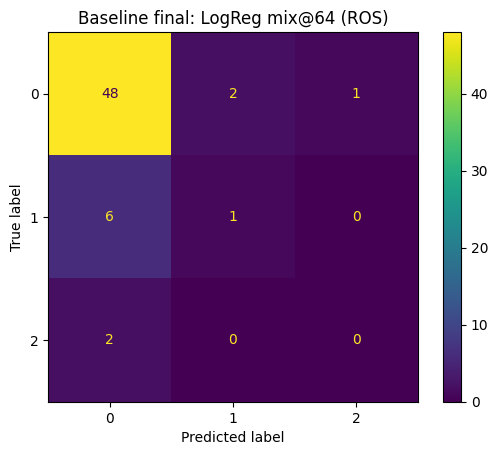

In [69]:
def show_report(model, Xtr, ytr, Xte, yte, title):
    if Xtr.size == 0 or Xte.size == 0 or len(ytr) == 0 or len(yte) == 0:
        print(f"{title}\n(Skipped: datos vacíos)")
        return

    model.fit(Xtr, ytr)
    pred_te = model.predict(Xte)

    print(title)
    print("\nBalanced Acc:", balanced_accuracy_score(yte, pred_te))
    print("F1-macro    :", f1_score(yte, pred_te, average="macro", zero_division=0))
    print("\nClassification report:\n", classification_report(yte, pred_te, digits=3, zero_division=0))

    cm = confusion_matrix(yte, pred_te)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(values_format="d")
    plt.title(title)
    plt.show()


Xtr_use, ytr_use, used = maybe_oversample(Xtr_mix, ytr_mix) if IMB_AVAILABLE else (Xtr_mix, ytr_mix, False)

title = f"Baseline final: LogReg mix@{SIZE} ({'ROS' if used else 'class_weight'})"
show_report(logreg_img, Xtr_use, ytr_use, Xte_mix, yte_mix, title)


## 9) Importancia de características (Permutation Importance)


In [ ]:
if Xte_mix.size == 0 or len(yte_mix) == 0:
    print("Permutation importance skipped: datos vacíos en test (mix).")
else:
    logreg_img.fit(Xtr_use, ytr_use)

    sample_n = min(300, Xte_mix.shape[0])
    X_imp = Xte_mix[:sample_n]
    y_imp = yte_mix[:sample_n]

    perm = permutation_importance(
        logreg_img, X_imp, y_imp,
        scoring="balanced_accuracy",
        n_repeats=10,
        random_state=RANDOM_STATE
    )

    importances = perm.importances_mean
    top_idx = np.argsort(importances)[::-1][:20]

    pd.DataFrame({
        "feature_index": top_idx,
        "importance_mean": importances[top_idx]
    })


## 10) Evidencia de sub/sobreajuste: Validación cruzada


In [ ]:
def cv_scores(model, X, y, label):
    if X.size == 0 or len(y) == 0:
        return {
            "label": label,
            "train_bal_acc_mean": np.nan,
            "val_bal_acc_mean": np.nan,
            "train_f1m_mean": np.nan,
            "val_f1m_mean": np.nan,
        }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

    scoring = {
        "bal_acc": "balanced_accuracy",
        "f1_macro": "f1_macro",
        "acc": "accuracy"
    }

    scores = cross_validate(
        model, X, y,
        cv=cv,
        scoring=scoring,
        return_train_score=True
    )

    return {
        "label": label,
        "train_bal_acc_mean": np.mean(scores["train_bal_acc"]),
        "val_bal_acc_mean": np.mean(scores["test_bal_acc"]),
        "train_f1m_mean": np.mean(scores["train_f1_macro"]),
        "val_f1m_mean": np.mean(scores["test_f1_macro"]),
    }


cv_out = cv_scores(logreg_img, Xtr_mix, ytr_mix, f"LogReg mix@{SIZE} (class_weight)")
pd.DataFrame([cv_out])


## 11) Desempeño mínimo
Comparación contra Dummy-stratified.


In [ ]:
if Xtr_mix.size == 0 or Xte_mix.size == 0 or len(ytr_mix) == 0 or len(yte_mix) == 0:
    print("Comparación Dummy vs LR skipped: datos vacíos en mix.")
else:
    dummy = DummyClassifier(strategy="stratified", random_state=RANDOM_STATE)
    dummy.fit(Xtr_mix, ytr_mix)
    pred_dummy = dummy.predict(Xte_mix)

    min_bal = balanced_accuracy_score(yte_mix, pred_dummy)
    min_f1m = f1_score(yte_mix, pred_dummy, average="macro", zero_division=0)

    logreg_img.fit(Xtr_use, ytr_use)
    pred_lr = logreg_img.predict(Xte_mix)

    bal_lr = balanced_accuracy_score(yte_mix, pred_lr)
    f1m_lr = f1_score(yte_mix, pred_lr, average="macro", zero_division=0)

    print("Dummy Balanced Acc:", min_bal, " Dummy F1-macro:", min_f1m)
    print("LR    Balanced Acc:", bal_lr, " LR    F1-macro:", f1m_lr)
    print("Δ Balanced Acc:", bal_lr - min_bal)
    print("Δ F1-macro    :", f1m_lr - min_f1m)
